# Quality control

Use this notebook to quality the analog forecast algorithm.

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import analog_forecast as af
from config import data_dir

## Tests

Run some tests on the various pieces of the algorithm.

Test the `rmse` function.

In [17]:
times = np.array(
    [
        d + " 12:00:00" 
        for d in ["2020-01-01", "2020-01-29", "2019-12-17", "1975-02-03", "1975-02-22"]
    ], 
    dtype=np.datetime64
)

# make a 5x2x2 array
da = xr.DataArray(
    data=np.arange(5 * 2 * 2).reshape(5, 2, 2),
    dims=["time", "latitude", "longitude"],
    coords=dict(
        time=times,
        latitude=[65, 64],
        longitude=[-147, -146]
    ),
)

# select the first slice of the da to be the reference da
ref_da = da.isel(time=0)

# append manually computed RMSE to accum list
rmse_values = np.array([np.sqrt(((ref_da - arr) ** 2).mean()) for arr in da])

test = af.rmse(da, ref_da)

# first should be 0 since we used the first slice as the reference array
assert rmse_values[0] == 0
assert np.all(test == rmse_values)

Test the `get_search_da` function with `window="any"`, which should discard timestamps which cannot allow 14-day forecasts, which are the last 14 timestamps of the series and the 14 dates before and after the reference date (because any forecast would include either the reference date or any of the dates to be forecasted).

With a reference date of 2020-01-10, and a time series comprised of 1/1 - 2/14, we would expect the only dates kept in the dataArray to be 1/25 - 1/31:

In [76]:
times = pd.date_range("2020-01-01 12:00:00", "2020-02-15 12:00:00")
exp_times = pd.date_range("2020-01-25 12:00:00", "2020-01-31 12:00:00")
ref_date = "2020-01-10"

# make a 5x2x2 array
da = xr.DataArray(
    data=np.arange(len(times) * 2 * 2).reshape(len(times), 2, 2),
    dims=["time", "latitude", "longitude"],
    coords=dict(
        time=times,
        latitude=[65, 64],
        longitude=[-147, -146]
    ),
)

test = af.get_search_da(da, ref_date, window="any")

assert np.all(test.time == exp_times)

Test the `take_analogs` function, which is used to extract the analogs from a DataArray of error scores based on certain conditions of how close analog dates may be.  Set up a DataArray that should yield times 2020-01-01 12:00:00 and 1975-02-22 12:00:00 `take_analogs` called with buffer=30 and n=2.

In [8]:
times = np.array(
    [
        d + " 12:00:00" 
        for d in ["2020-01-01", "2020-01-29", "2019-12-17", "1975-02-03", "1975-02-22"]
    ], 
    dtype=np.datetime64
)

da = xr.DataArray(
    data=[1, 2, 3, 4, 1.2],
    dims=["time"],
    coords=dict(
        time=times,
    ),
)

test = af.take_analogs(da, 30, 2)

exp_times = times[[0, -1]]
assert np.all(test == da.sel(time=exp_times))

Test the `make_forecast` function. This should accept a DataArray, reference date, and dates to generate forecasts from, as means of each corresponding time slice following the dates. This should work for any number of dates so we will supply 3, with a time series comprised of these three dates and the 14 days following each. 

In [97]:
times = pd.date_range("2020-01-01 12:00:00", "2020-02-14 12:00:00")
analog_time_idx = np.array([0, 15, 30])
analog_times = [times[i] for i in analog_time_idx]
ref_date = "2020-02-15"

# make a 5x2x2 array
da = xr.DataArray(
    data=np.arange(len(times) * 2 * 2).reshape(len(times), 2, 2),
    dims=["time", "latitude", "longitude"],
    coords=dict(
        time=times,
        latitude=[65, 64],
        longitude=[-147, -146]
    ),
)

test_forecast = af.make_forecast(da, analog_times, ref_date)
# iterate over 1-14 days past each of the analog times, pull from da, and take means to compute forecasts
forecasts = [da.isel(time=analog_time_idx + i).mean(axis=0) for i in range(1, 15)]

assert np.all(forecasts == test_forecast)

## Validation

Validate the functions for reading ERA5 data and subsetting it spatially, and plotting, and making sure things looks reasonable.

Open the ERA5 raw air temperature dataset, susbet it to Alaska.

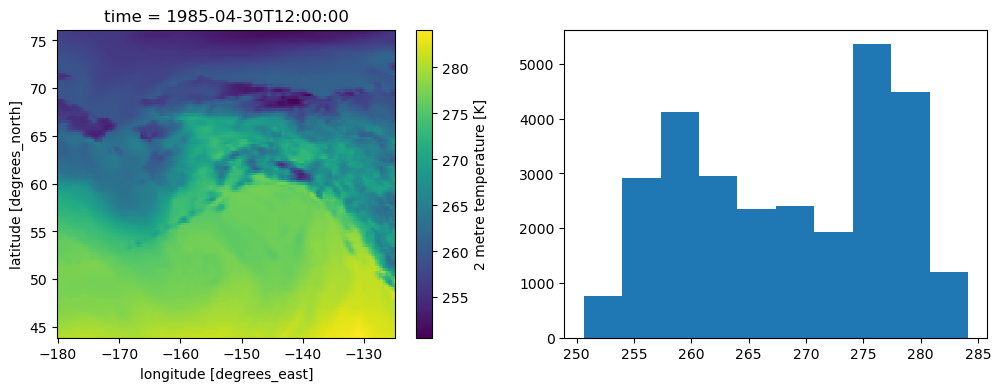

In [49]:
spatial_domain = "alaska"
varname = "t2m"
use_anom = False

def validate_read_and_subset():
    sub_da = af.read_subset_era5(spatial_domain, data_dir, varname, use_anom)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sel_time = np.random.choice(sub_da.time.values)
    sub_da.sel(time=sel_time).plot(ax=ax[0])
    ax=ax[1].hist(sub_da.sel(time=sel_time).values.flatten())
    
validate_read_and_subset()

Check out a couple more files:

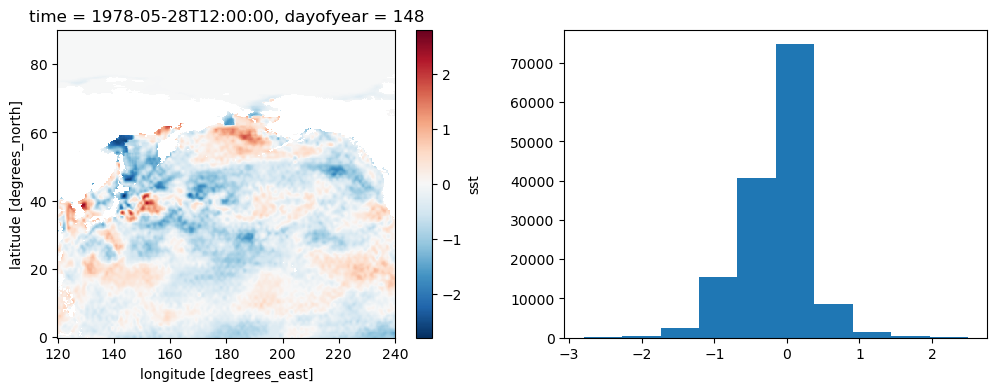

In [50]:
spatial_domain = "north_pacific"
varname = "sst"
use_anom = True
validate_read_and_subset()

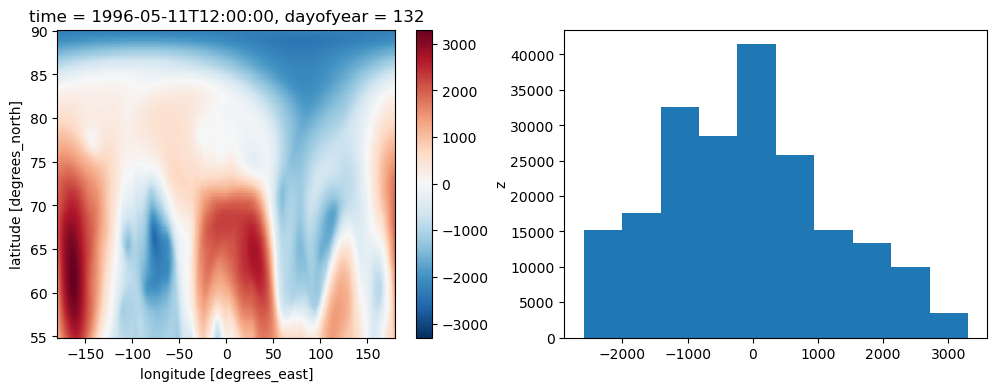

In [51]:
spatial_domain = "panarctic"
varname = "z"
use_anom = True
validate_read_and_subset()

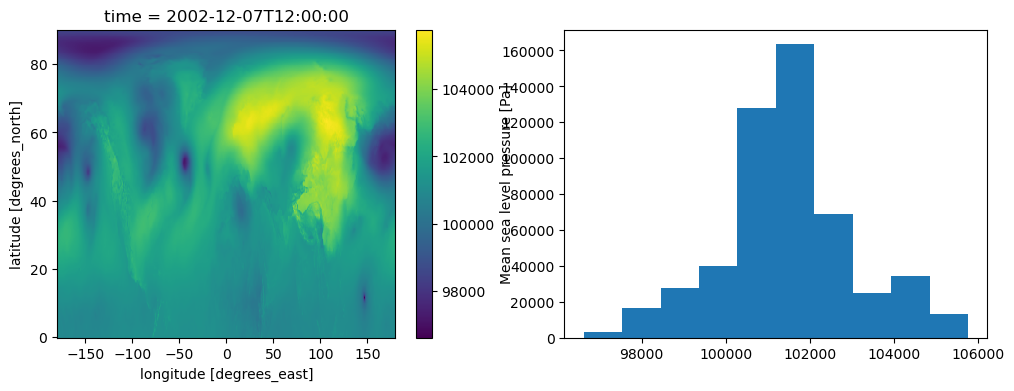

In [52]:
spatial_domain = "northern_hs"
varname = "msl"
use_anom = False
validate_read_and_subset()

### Analog forecast

Finally, validate the analog forecast method itself by running it and plotting some results:

In [103]:
%%time
varname = "t2m"
spatial_domain = "alaska"
ref_date = "2021-07-01"
use_anom = True

sub_da = af.read_subset_era5(spatial_domain, data_dir, varname, use_anom=use_anom)
analogs = af.find_analogs(sub_da, ref_date, print_analogs=True)
# need to load and subset raw data as wel for forecast with anomaly based search
raw_sub_da = af.read_subset_era5(spatial_domain, data_dir, varname, use_anom=False)
forecast = af.make_forecast(raw_sub_da, analogs.time.values, ref_date)

   Top 5 Analogs: 
Rank 1:   Date: 2018-05-24;  RMSE: 1.727
Rank 2:   Date: 1989-08-16;  RMSE: 1.777
Rank 3:   Date: 2016-08-21;  RMSE: 1.809
Rank 4:   Date: 2002-07-22;  RMSE: 1.816
Rank 5:   Date: 2018-07-11;  RMSE: 1.819
CPU times: user 6.79 s, sys: 5.9 s, total: 12.7 s
Wall time: 12.7 s


Compare top analogs with some randomly chosen dates by plotting the difference between the analogs and the reference date, as well as between the random dates and reference date. Make a column with the 5 analogs on the left, and column with the 5 random choices (naive analogs) on the right. 

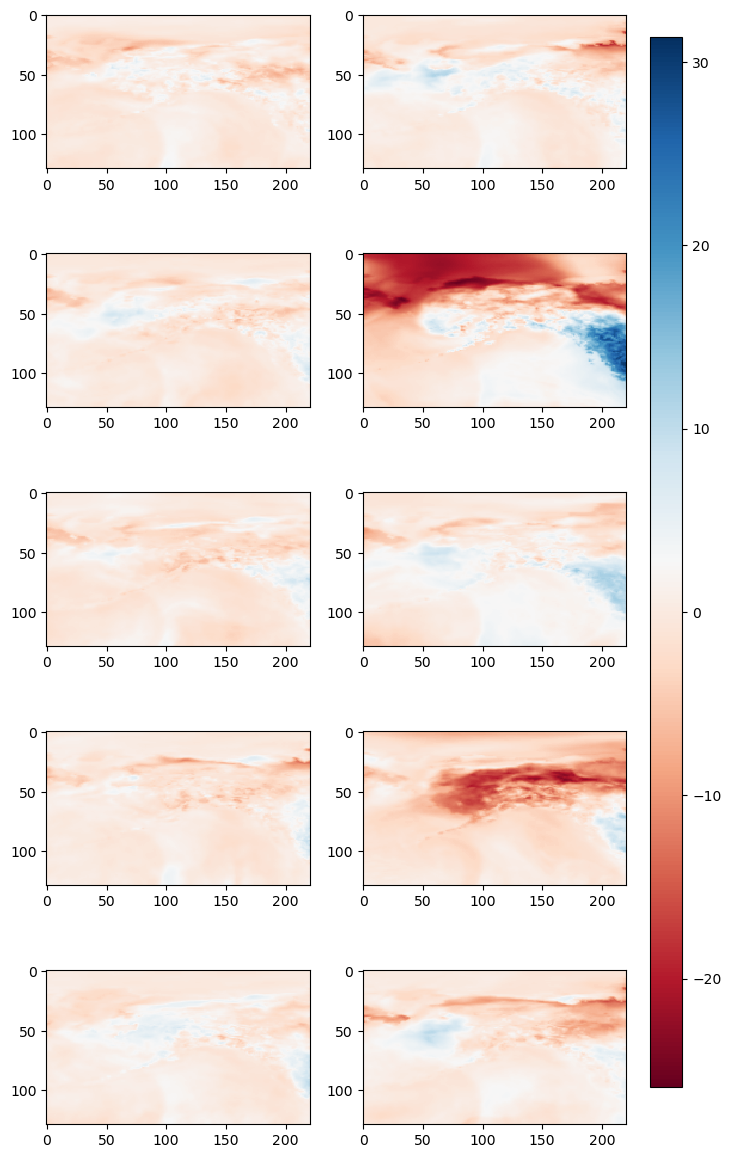

In [134]:
fig, axes = plt.subplots(5, 2, figsize=(8, 15))
# accumulate diffs for a common color scale
all_deltas = []
for analog in analogs:
    analog_deltas = (sub_da.sel(time=ref_date) - sub_da.sel(time=analog.time.values)).squeeze()
    random_date = np.random.choice(sub_da.time.values)
    # (sub_da.sel(time=ref_date) - sub_da.sel(time=random_date)).plot(ax=ax_row[1])
    naive_deltas = (sub_da.sel(time=ref_date) - sub_da.sel(time=random_date)).squeeze()
    all_deltas.append((analog_deltas, naive_deltas))
    
vmin, vmax = np.min(all_deltas), np.max(all_deltas)
plot_kwargs = dict(interpolation="none", vmin=vmin, vmax=vmax, cmap="RdBu")
    
for deltas, ax_row in zip(all_deltas, axes):
    im = ax_row[0].imshow(deltas[0], **plot_kwargs)
    ax_row[1].imshow(deltas[1], **plot_kwargs)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)

end